# **Tecnical Report: MINA-BR-2 dataset benchmark with use of stemming** 

# Notebook Description

This notebook contains the pre-processing of MINA-BR-2 dataset, using stemming techiniques.

It also contains a baseline result for this dataset for five different algorithms: SVM, Random Forest and Naive Bayes (Gaussian, Bernoulli and Multinomial). A more detailed description of the results can be found in LINK.

# Imported Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import data_table

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

%load_ext google.colab.data_table

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from string import punctuation
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import re
import string

#Load dataset 

In [ ]:
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Dataset with 3 annotators
id = '1TclPZv1Fgp2GJRqPAV-YpEpT9_RaPYiI'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('outputJson.csv')  
base_1 = pd.read_csv('outputJson.csv')

#Dataset with 2 annotators
id = '1nwLLVWGcSZDz9-Qlu05nVpjBHI47h9RC'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('outputJson2.csv')  
base_2 = pd.read_csv('outputJson2.csv')
base_2['ofens_clas_3'] = None
base_2['disc_clas_3'] = None

## Dataset with 3 annotators

In [ ]:
#hate label is given to a comment if at least 2 annotators have classified the comment as hate
base_1['hate'] = np.where(base_1['disc_clas_1']+base_1['disc_clas_2']+base_1['disc_clas_3']>1, 1, 0)
#offensive label is given to a comment if at least 2 annotators have classified the comment as offensive
base_1['offensive'] = np.where(base_1['ofens_clas_1']+base_1['ofens_clas_2']+base_1['ofens_clas_3']>1, 1, 0)
base_1['nº annotators'] = 3
base_1['nº agree with label'] = np.where((base_1['disc_clas_1']+base_1['disc_clas_2']+base_1['disc_clas_3'])%3 == 0, 3, 2)

#--------------------------#
print("If at least two annotators have classified the comment as hate then it's given the HATE label.\n Number of comments classified as HATE(1) and NO HATE(0):\n")
print(base_1['hate'].value_counts())
print("\nIf at least two annotators have classified the comment as offensive then it's given the OFFENSIVE label.\n Number of comments classified as OFFENSIVE(1) and NOT OFFENSIVE(0):\n")
print(base_1['offensive'].value_counts())
#data_table.DataTable(base_1, num_rows_per_page=5)

If at least two annotators have classified the comment as hate then it's given the HATE label.
 Number of comments classified as HATE(1) and NO HATE(0):

0    518
1    205
Name: hate, dtype: int64

If at least two annotators have classified the comment as offensive then it's given the OFFENSIVE label.
 Number of comments classified as OFFENSIVE(1) and NOT OFFENSIVE(0):

0    417
1    306
Name: offensive, dtype: int64


## Dataset with 2 annotators

In [ ]:
#if both annotators have considered the comment as hate it receives the hate label
base_2['hate'] = np.where(base_2['disc_clas_1'] + base_2['disc_clas_2'] == 2, 1, 0)
#if both annotators have considered the comment as offensive it receives the offensive label
base_2['offensive'] = np.where(base_2['ofens_clas_1'] + base_2['ofens_clas_2'] == 2, 1, 0)
#information on the amount of annotators
base_2['nº annotators'] = 2
base_2['nº agree with label'] = 2

#--------------------------#
print("If the 2 annotators have considered the comment as hate, then it's given the label HATE.\n Number of HATE(1) and NO HATE(0) comments:\n")
print(base_2['hate'].value_counts())
print("\nIf the 2 annotators have considered the comment as offensive, then it's given the label OFFENSIVE.\n Number of OFFENSIVE(1) and NOT OFFENSIVE(0) comments:\n")
print(base_2['offensive'].value_counts())
#data_table.DataTable(base_2, num_rows_per_page=5)

If the 2 annotators have considered the comment as hate, then it's given the label HATE.
 Number of HATE(1) and NO HATE(0) comments:

0    345
1     82
Name: hate, dtype: int64

If the 2 annotators have considered the comment as offensive, then it's given the label OFFENSIVE.
 Number of OFFENSIVE(1) and NOT OFFENSIVE(0) comments:

0    316
1    111
Name: offensive, dtype: int64


## Concatenating the datasets

In [ ]:
base = pd.concat([base_1, base_2], ignore_index=True)
print("If at least two annotators have classified the comment as hate then it's given the HATE label.\n Number of comments classified as HATE(1) and NO HATE(0):\n")
print(base['hate'].value_counts())
print("\nIf at least two annotators have classified the comment as offensive then it's given the OFFENSIVE label.\n Number of comments classified as OFFENSIVE(1) and NOT OFFENSIVE(0):\n")
print(base['offensive'].value_counts())
#data_table.DataTable(base, num_rows_per_page=5)

If at least two annotators have classified the comment as hate then it's given the HATE label.
 Number of comments classified as HATE(1) and NO HATE(0):

0    863
1    287
Name: hate, dtype: int64

If at least two annotators have classified the comment as offensive then it's given the OFFENSIVE label.
 Number of comments classified as OFFENSIVE(1) and NOT OFFENSIVE(0):

0    733
1    417
Name: offensive, dtype: int64


In [ ]:
#change the order of the columns
df = base.copy()
df = df[[ 'comment', 'date', 'keyword', 'source', 'userID_videoID', 'nº annotators', 'nº agree with label','ofens_clas_1', 'ofens_clas_2', 'ofens_clas_2', 'disc_clas_1', 'disc_clas_2', 'disc_clas_3','offensive','hate' ]]
data_table.DataTable(df, num_rows_per_page=5)


,comment,date,keyword,source,userID_videoID,nº annotators,nº agree with label,ofens_clas_1,ofens_clas_2,ofens_clas_2,disc_clas_1,disc_clas_2,disc_clas_3,offensive,hate
0,Quando vejo uma mulher antifeminista eu só con...,2020-12-23 19:31:28,antifeminista,Twitter,386034034,3,3,0,0,0,0,0,0,0,0
1,"@NOME ai amg essa garota é um saco, é antifemi...",2020-12-22 23:14:30,antifeminista,Twitter,1200867040774557700,3,3,0,0,0,0,0,0,0,0
2,Cancelando a T.T. mas não para o cu em casa 🤪🥰...,2020-12-28 20:00:39,thelma,Twitter,332579359,3,2,1,1,1,0,1,1,1,1
3,Nunca! #AbortoNao,2020-12-30 18:46:47,#abortonao,Twitter,163015830,3,2,0,1,1,0,0,1,1,0
4,"@NOME Ctz que nao estao só as 4... mas tipo, s...",2020-12-28 20:06:41,thelma,Twitter,53777854,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,Quem ouvindo em 2019 ?,2019-11-17T17:32:53Z,todo_dia_podcast_mgtow,Youtube,Tbwi0P_VNzY,2,2,0,0,0,0,0,None,0,0
1146,Foda no Japão estrangeiro não pode entra no pu...,2020-06-19T01:55:27Z,todo_dia_podcast_mgtow,Youtube,DIYvpb7bSYE,2,2,0,0,0,0,0,None,0,0
1147,"Bruno, agora tem a música da Letícia!",2020-12-21T03:51:02Z,social arts,Youtube,zziTi8zFYqc,2,2,0,0,0,0,0,None,0,0
1148,"Nossa Antônio vc não para de falar, a entrevi...",2020-11-05T17:57:31Z,mariana_ferrer,Youtube,6rQ0uwUG1CQ,2,2,0,0,0,0,0,None,0,0


#Pre-processing

###Functions

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

#list of stopwords
my_list = ['\\']
cache_portuguese_stopword = set(stopwords.words('portuguese') + my_list)

#functions

def tweet_clean(tweet):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
  # Remove tickers
  sent_no_tickers=re.sub(r'\$\w*','',tweet)
  tw_tknzr=TweetTokenizer(strip_handles=True, reduce_len=True)
  temp_tw_list = tw_tknzr.tokenize(sent_no_tickers)
  #lowercase
  list_lowercase = [word.lower() for word in temp_tw_list]
  # Remove stopwords
  list_no_stopwords=[i for i in list_lowercase if i not in     cache_portuguese_stopword ]
  # Remove hyperlinks
  list_no_hyperlinks=[re.sub(r'https?:\/\/.*\/\w*','',i) for i in list_no_stopwords]
  # Remove hashtags
  list_no_hashtags=[re.sub(r'#', '', i) for i in list_no_hyperlinks]
  #remove emojis
  list_no_emojis = [emoji_pattern.sub(r'', i) for i in list_no_hashtags]
  # Remove Punctuation and split 's, 't, 've with a space for filter
  list_no_punctuation=[re.sub(r'['+string.punctuation+']+', ' ', i) for i in list_no_emojis]
  # Remove multiple whitespace
  new_sent = ' '.join(list_no_punctuation)
  # Remove any words with 2 or fewer letters
  #filtered_list = tw_tknzr.tokenize(new_sent)
  #list_filtered = [re.sub(r'^\w\w?$', '', i) for i in filtered_list]
  #filtered_sent =' '.join(list_filtered)
  #clean_sent=re.sub(r'\s\s+', ' ', filtered_sent)
  return new_sent

def plotWordCloud(data_tokenized):
  from wordcloud import WordCloud
  allWordsinRows = data_tokenized[:][:]
  allWords = []

  for words in allWordsinRows:
    allWords.extend(words)

  # The FreqDist class is used to encode “frequency distributions”, which count
  # the number of times that each outcome of an experiment occurs
  # FreqDist devolve um dicionário onde cada key é uma palavra distinta (?)

  frequencia = nltk.FreqDist(allWords)
  sorted(frequencia, key = frequencia.__getitem__, reverse = True)

  wordcloud = WordCloud().generate_from_frequencies(frequencia)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

  return allWordsinRows, frequencia

def plotFrenquencies(fr):
  fr.plot(20,cumulative=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Dataset features before cleaning

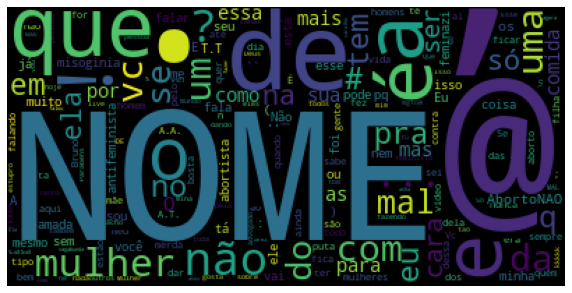


Number of features without pre-processing:  5649


In [ ]:
tokenized_df= df['comment'].apply(word_tokenize)
allWords_original, freq_original = plotWordCloud(tokenized_df)
features_original = list(freq_original.keys())[:]
print('\nNumber of features without pre-processing: ',len(features_original))

###Cleaning the dataset

In [ ]:
clean_tweets = df['comment'].apply(tweet_clean)
new_col = pd.DataFrame({'comment': clean_tweets})
df.update(new_col)
#data_table.DataTable(df, num_rows_per_page=5)

In [ ]:
#Tokenize the Data Frame
tokenized_base= df['comment'].apply(word_tokenize)
#Tokenize Hate Data Frame
hate_base = df.loc[df['hate']== 1]
tokenized_hate_base = hate_base['comment'].apply(word_tokenize)
#Tokenize No Hate Data Frame
no_hate_base = df.loc[df['hate']== 0]
tokenized_no_hate_base= no_hate_base['comment'].apply(word_tokenize)

###Stemming

In [ ]:
#functions

from nltk.stem import RSLPStemmer
nltk.download('rslp')

def rslpstemmer(text):
  texto_filtrado = []
  text = nltk.word_tokenize(text)
  stemmer = RSLPStemmer()
  for word in text:
    texto_filtrado.append(stemmer.stem(word.lower()))

  return (texto_filtrado)

from nltk.stem.snowball import SnowballStemmer

def stemming_snowball(text):
  texto_filtrado = []
  text = nltk.word_tokenize(text)
  portugueseStemmer = SnowballStemmer('portuguese')

  for word in text:
    texto_filtrado.append(portugueseStemmer.stem(word.lower()))

  return (texto_filtrado)


[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
#RSLP Stemmer

data_stemming_rslp= df[:]['comment'].apply(rslpstemmer)
df_rslp = df.copy()
df_rslp['comment'] = data_stemming_rslp
data_table.DataTable(df_rslp, num_rows_per_page=5)

,comment,date,keyword,source,userID_videoID,nº annotators,nº agree with label,ofens_clas_1,ofens_clas_2,ofens_clas_2,disc_clas_1,disc_clas_2,disc_clas_3,offensive,hate
0,"[vej, mulh, antifemin, consig, pens]",2020-12-23 19:31:28,antifeminista,Twitter,386034034,3,3,0,0,0,0,0,0,0,0
1,"[ai, amg, garot, sac, antifemin, gordofob, sér...",2020-12-22 23:14:30,antifeminista,Twitter,1200867040774557700,3,3,0,0,0,0,0,0,0,0
2,"[cancel, t, t, cu, cas, 🥰, 🤤, 🥳]",2020-12-28 20:00:39,thelma,Twitter,332579359,3,2,1,1,1,0,1,1,1,1
3,"[nunc, abortona]",2020-12-30 18:46:47,#abortonao,Twitter,163015830,3,2,0,1,1,0,0,1,1,0
4,"[ctz, nao, esta, 4, tip, ide, privilegi, alug,...",2020-12-28 20:06:41,thelma,Twitter,53777854,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,"[ouv, 2019]",2019-11-17T17:32:53Z,todo_dia_podcast_mgtow,Youtube,Tbwi0P_VNzY,2,2,0,0,0,0,0,None,0,0
1146,"[fod, jap, estrang, pod, entr, put]",2020-06-19T01:55:27Z,todo_dia_podcast_mgtow,Youtube,DIYvpb7bSYE,2,2,0,0,0,0,0,None,0,0
1147,"[brun, agor, músic, letíc]",2020-12-21T03:51:02Z,social arts,Youtube,zziTi8zFYqc,2,2,0,0,0,0,0,None,0,0
1148,"[antôni, vc, fal, entrevist, conseg, fal]",2020-11-05T17:57:31Z,mariana_ferrer,Youtube,6rQ0uwUG1CQ,2,2,0,0,0,0,0,None,0,0


In [ ]:
#Snowball Portuguese Stemmer

data_stemming_snow = df[:]['comment'].apply(stemming_snowball)
df_snow = df.copy()
df_snow['comment'] = data_stemming_snow
data_table.DataTable(df_snow, num_rows_per_page=5)

,comment,date,keyword,source,userID_videoID,nº annotators,nº agree with label,ofens_clas_1,ofens_clas_2,ofens_clas_2,disc_clas_1,disc_clas_2,disc_clas_3,offensive,hate
0,"[vej, mulh, antifemin, consig, pens]",2020-12-23 19:31:28,antifeminista,Twitter,386034034,3,3,0,0,0,0,0,0,0,0
1,"[ai, amg, garot, sac, antifemin, gordofob, sér...",2020-12-22 23:14:30,antifeminista,Twitter,1200867040774557700,3,3,0,0,0,0,0,0,0,0
2,"[cancel, t, t, cu, cas, 🥰, 🤤, 🥳]",2020-12-28 20:00:39,thelma,Twitter,332579359,3,2,1,1,1,0,1,1,1,1
3,"[nunc, abortona]",2020-12-30 18:46:47,#abortonao,Twitter,163015830,3,2,0,1,1,0,0,1,1,0
4,"[ctz, nao, esta, 4, tip, ide, privilegi, alug,...",2020-12-28 20:06:41,thelma,Twitter,53777854,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,"[ouv, 2019]",2019-11-17T17:32:53Z,todo_dia_podcast_mgtow,Youtube,Tbwi0P_VNzY,2,2,0,0,0,0,0,None,0,0
1146,"[fod, japã, estrangeir, pod, entra, puteir]",2020-06-19T01:55:27Z,todo_dia_podcast_mgtow,Youtube,DIYvpb7bSYE,2,2,0,0,0,0,0,None,0,0
1147,"[brun, agor, músic, letíc]",2020-12-21T03:51:02Z,social arts,Youtube,zziTi8zFYqc,2,2,0,0,0,0,0,None,0,0
1148,"[antôni, vc, fal, entrevist, conseg, fal]",2020-11-05T17:57:31Z,mariana_ferrer,Youtube,6rQ0uwUG1CQ,2,2,0,0,0,0,0,None,0,0


###Word Clouds

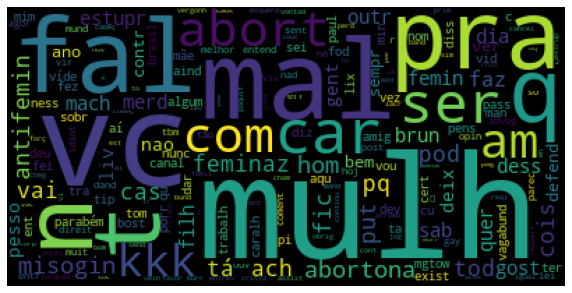

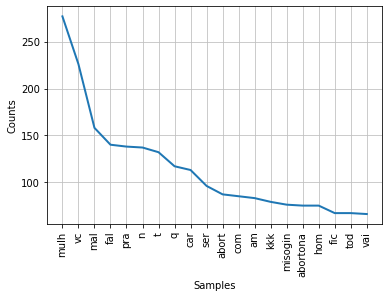

Number of features of clean RSLP data:  3120


In [ ]:
#RSLP
allWords_RSLP, frequencies_RSLP= plotWordCloud(data_stemming_rslp )
plotFrenquencies(frequencies_RSLP)
features_rslp = list(frequencies_RSLP.keys())[:]
print("Number of features of clean RSLP data: ",len(features_rslp))

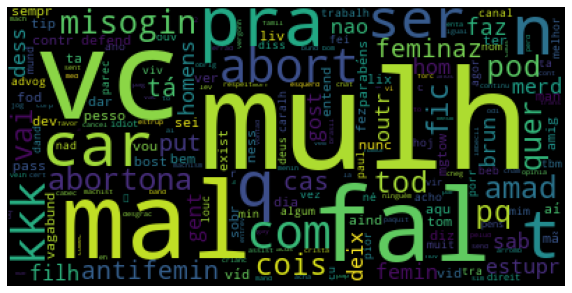

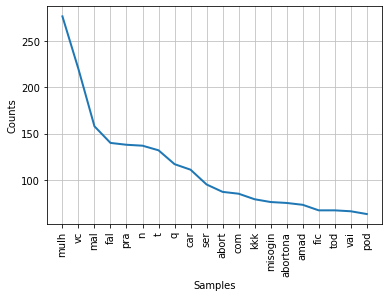

Number of features of clean Snowball data:  3303


In [ ]:
#Snowball
allWords_snow, frequencies_snow= plotWordCloud(data_stemming_snow )
plotFrenquencies(frequencies_snow)
features_snow = list(frequencies_snow.keys())[:]
print("Number of features of clean Snowball data: ",len(features_snow))

#Bag of Words

In [ ]:
#function

def extractNumericalBoW(frase, total_features_map):
  words = set(frase)
  word_features = {}

  for w in total_features_map:
    count = 0

    for word in words:
      if word == w:
        count = count+1

    word_features[w] = count

  return word_features

In [ ]:
#----------Snowball------------

#list with all the existing different words 
total_features_snow = list(frequencies_snow.keys())[:]

#list of labels
Y_data_snow = [label for label in df_snow[:]['hate']]
X_data_snow = []

for i in range(len(allWords_snow)):
  X_data_snow.append((extractNumericalBoW(allWords_snow[i], total_features_snow), Y_data_snow[i]))

#------------RSLP---------------

#list with all the existing different words 
total_features_rslp = list(frequencies_RSLP.keys())[:]

#list of labels
Y_data_rslp = [label for label in df_rslp[:]['hate']]
X_data_rslp = []

for i in range(len(allWords_RSLP)):
  X_data_rslp.append((extractNumericalBoW(allWords_RSLP[i], total_features_rslp), Y_data_rslp[i]))

#Classification

###Functions

In [ ]:
from sklearn.model_selection import StratifiedKFold

def TrainClassifierWithScore (kfold, X_data_np, Y_data_np, classifier_type):

  scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

  cv = StratifiedKFold(n_splits = kfold, shuffle = True, random_state = 42)

  if classifier_type == 'svm_poly':
    classifier = SVC(kernel='poly', C=0.45, probability=True, gamma='auto', class_weight='balanced')
      
  elif classifier_type == 'svm_rbf':
    classifier = SVC(kernel='rbf', C=0.45, probability=True, gamma='auto', class_weight='balanced')

  elif classifier_type == 'svm_linear':
    classifier = SVC(kernel='linear', C=0.2, probability=True, gamma='auto', class_weight='balanced')

  elif classifier_type == 'naive_gaussiano':
    classifier = GaussianNB()

  elif classifier_type == 'naive_bernoulli':
    classifier = BernoulliNB(binarize = None)
   
  elif classifier_type == 'naive_multinomial':
    classifier = MultinomialNB()

  elif classifier_type == 'random_forest':
    classifier = RandomForestClassifier(n_estimators=200)

  results = cross_validate(estimator = classifier, X = X_data_np, y = Y_data_np, cv = cv, scoring = scoring, return_train_score = True)

  return results

def DictToArray(X_data):

  X_data_array = []
  Y_data_array = []

  for X in X_data:
    feature = []
    for feat in X[0].values():
      feature.append(feat)

    X_data_array.append(feature)
    Y_data_array.append(X[1])

  X_data_np = np.array(X_data_array)
  Y_data_np = np.array(Y_data_array, dtype = int)

  return X_data_np, Y_data_array

def printScoreTable(scores, kfold, classifier_type):
  print("\nClassifier:%s" % classifier_type)
  print("K:\tAcc.:\tPre:\tRec.:\tF1-S.:")
  mean_acc = 0
  mean_pre = 0
  mean_rec = 0
  mean_f1 = 0
  for i in range(kfold):
    mean_acc += (scores['test_accuracy'])[i]
    mean_pre += (scores['test_precision'])[i]
    mean_rec += (scores['test_recall'])[i]
    mean_f1 += (scores['test_f1'])[i]
    print("%i\t%.4f\t%.4f\t%.4f\t%.4f\t" % (i+1, scores['test_accuracy'][i], scores['test_precision'][i], scores['test_recall'][i], scores['test_f1'][i]))
  
  print("Mean\t%.4f\t%.4f\t%.4f\t%.4f\t" % (mean_acc/kfold, mean_pre/kfold, mean_rec/kfold, mean_f1/kfold))

##RSLP

###Search for the best parameters

In [ ]:
#transforming the data from dictionary to array format
X_data_np_rslp, Y_data_np_rslp = DictToArray(X_data_rslp)

In [ ]:
kfold = 5

scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

# -----------SVM -------------

svm_parameters = {
    'kernel': ['linear','poly','rbf'],
    'gamma': ['auto', 'scale'],
    'C': [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.7, 0.8],
    'class_weight' : ['balanced']
}

svm_grid_rslp = GridSearchCV(
    estimator = SVC(),
    param_grid = svm_parameters,
    cv = cv,
    scoring = scoring,
    refit =  'f1',
    verbose = 3
)

svm_grid_rslp.fit(X_data_np_rslp, Y_data_np_rslp)

In [ ]:
# ----------Random Forest -------------

parametros_forest = {
    'n_estimators': [100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [80, 90, 100, 110],
    'min_samples_split'  : [2, 5, 8, 10],
    'min_samples_leaf' : [1, 3, 5]
}

grid_forest_rslp = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parametros_forest,
    scoring = scoring,
    refit = 'f1',
    cv = 5,
    verbose = 3
)

grid_forest_rslp.fit(X_data_np_rslp, Y_data_np_rslp)

In [ ]:
print("Best svm F1 Score: ", svm_grid_rslp.best_score_)
print("Best svm Score Parameters: ", svm_grid_rslp.best_params_)

print("Best random forest F1 Score: ", grid_forest_rslp.best_score_)
print("Best random forest Score Parameters: ", grid_forest_rslp.best_params_)

Best svm F1 Score:  0.5949552967945972
Best svm Score Parameters:  {'C': 0.2, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
Best random forest F1 Score:  0.5728325404667135
Best random forest Score Parameters:  {'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
kfold = 5

#training linear SVM model
score_svm_linear_rslp = TrainClassifierWithScore(kfold, X_data_np_rslp, Y_data_np_rslp, 'svm_linear')
#training Random Forest model
score_forest_rslp = TrainClassifierWithScore(kfold, X_data_np_rslp, Y_data_np_rslp, 'random_forest')
#training Gaussian Naive Bayes
score_naive_gaussiano_rslp = TrainClassifierWithScore(kfold, X_data_np_rslp, Y_data_np_rslp, 'naive_gaussiano')
#training Bernoulli Naive Bayes
score_naive_bernoulli_rslp = TrainClassifierWithScore(kfold, X_data_np_rslp, Y_data_np_rslp, 'naive_bernoulli')
#training Multinomial Naive Bayes
score_naive_multinomial_rslp = TrainClassifierWithScore(kfold, X_data_np_rslp, Y_data_np_rslp, 'naive_multinomial')

In [ ]:
#Print Score Table

#Linear SVM
printScoreTable(score_svm_linear_rslp, kfold, 'svm_linear')
#Random Forest
printScoreTable(score_forest_rslp, kfold, 'random_forest')
#Gaussian Naive Bayes
printScoreTable(score_naive_gaussiano_rslp, kfold, 'naive_bayes_gaussiano')
#Bernoulli Naive Bayes
printScoreTable(score_naive_bernoulli_rslp, kfold, 'naive_bayes_bernoulli')
#Multinomial Naive Bayes
printScoreTable(score_naive_multinomial_rslp, kfold, 'naive_bayes_multinomial')


Classifier:svm_linear
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7870	0.5690	0.5789	0.5739	
2	0.7783	0.5405	0.7018	0.6107	
3	0.8174	0.6667	0.5263	0.5882	
4	0.8043	0.6140	0.6034	0.6087	
5	0.8000	0.6250	0.5172	0.5660	
Mean	0.7974	0.6030	0.5855	0.5895	

Classifier:random_forest
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.8435	0.8182	0.4737	0.6000	
2	0.8478	0.7037	0.6667	0.6847	
3	0.8217	0.7500	0.4211	0.5393	
4	0.8435	0.8235	0.4828	0.6087	
5	0.8391	0.8182	0.4655	0.5934	
Mean	0.8391	0.7827	0.5019	0.6052	

Classifier:naive_bayes_gaussiano
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.6435	0.3494	0.5088	0.4143	
2	0.6435	0.3563	0.5439	0.4306	
3	0.6957	0.4110	0.5263	0.4615	
4	0.6348	0.3415	0.4828	0.4000	
5	0.6435	0.3421	0.4483	0.3881	
Mean	0.6522	0.3600	0.5020	0.4189	

Classifier:naive_bayes_bernoulli
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7478	0.4706	0.1404	0.2162	
2	0.7522	0.5000	0.1579	0.2400	
3	0.7565	0.5263	0.1754	0.2632	
4	0.7870	0.7143	0.2586	0.3797	
5	0.7522	0.5172	0.2586	0.3448	
Mean	0.7591	0.5457	0.1982	0.2888	

Classifier:naive_b

###Training

#### Splitting dataset

In [ ]:
y_data_rslp = pd.Series(Y_data_np_rslp)

In [ ]:
from sklearn.model_selection import train_test_split
# 75% of the dataset -> train
x_train_rslp, x_test_rslp, y_train_rslp, y_test_rslp = train_test_split(X_data_np_rslp, y_data_rslp, random_state = 42, stratify = y_data_rslp)

In [ ]:
index_train = y_train_rslp.keys()
index_test = y_test_rslp.keys()

base_train_rslp = df_rslp.iloc[index_train]
base_test_rslp = df_rslp.iloc[index_test]

print('Hate label proportion in the train and test datasets:')
print('Train dataset:\n')
print(base_train_rslp['hate'].value_counts())
print('\nTest dataset:\n')
print(base_test_rslp['hate'].value_counts())

Hate label proportion in the train and test datasets:
Train dataset:

0    647
1    215
Name: hate, dtype: int64

Test dataset:

0    216
1     72
Name: hate, dtype: int64


In [ ]:
print('Number of annotators that agree with the label:')
print('\nTrain dataset:\n')
print(base_train_rslp['nº agree with label'].value_counts())
print('\nTest dataset:\n')
print(base_test_rslp['nº agree with label'].value_counts())

Number of annotators that agree with the label:

Train dataset:

2    488
3    374
Name: nº agree with label, dtype: int64

Test dataset:

2    179
3    109
Name: nº agree with label, dtype: int64


####SVM

In [ ]:
#train with best parameters found at GridSearch

classifier_svm_rslp = SVC(kernel = 'linear', C = 0.2, probability = True, gamma = 'auto', class_weight = 'balanced')
classifier_svm_rslp.fit(x_train_rslp,y_train_rslp)

In [ ]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
y_predict_svm_linear_rslp = classifier_svm_rslp.predict(x_test_rslp)
print("SVM: Confusion Matrix\n")
print(confusion_matrix(y_test_rslp, y_predict_svm_linear_rslp))

#F1-Score and Accuracy
from sklearn.metrics import f1_score
print("\nF1 Score: ", f1_score(y_test_rslp, y_predict_svm_linear_rslp))
from sklearn.metrics import accuracy_score
print("\nAccuracy: ", accuracy_score(y_test_rslp, y_predict_svm_linear_rslp))

SVM: Confusion Matrix

[[188  28]
 [ 32  40]]

F1 Score:  0.5714285714285715

Accuracy:  0.7916666666666666


In [ ]:
#splitting the test data by results: false positive, false negative, true positive, true negative
data_rslp = y_test_rslp.array

base_test_rslp['SVM result'] = ''

for i in range (len(data_rslp)):
  if data_rslp[i] == y_predict_svm_linear_rslp[i]:
    if data_rslp[i] == 1:
      base_test_rslp.loc[index_test[i], 'SVM result'] = 'TP'
    else:
      base_test_rslp.loc[index_test[i], 'SVM result'] = 'TN'
  if data_rslp[i] != y_predict_svm_linear_rslp[i]:
    if y_predict_svm_linear_rslp[i] == 1:
      base_test_rslp.loc[index_test[i], 'SVM result'] = 'FP'
    if y_predict_svm_linear_rslp[i] == 0:
      base_test_rslp.loc[index_test[i], 'SVM result'] = 'FN'

In [ ]:
TP_svm_rslp = base_test_rslp.loc[base_test_rslp['SVM result'] == 'TP']
TN_svm_rslp = base_test_rslp.loc[base_test_rslp['SVM result'] == 'TN']
FN_svm_rslp = base_test_rslp.loc[base_test_rslp['SVM result'] == 'FN']
FP_svm_rslp = base_test_rslp.loc[base_test_rslp['SVM result'] == 'FP']

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
#Saving dataframe at drive
TP_svm_rslp.to_csv('/drive/My Drive/tp_svm_rslp.csv')
TN_svm_rslp.to_csv('/drive/My Drive/tn_svm_rslp.csv')
FN_svm_rslp.to_csv('/drive/My Drive/fn_svm_rslp.csv')
FP_svm_rslp.to_csv('/drive/My Drive/fp_svm_rslp.csv')

####Random Forest

In [ ]:
#train with best parameters found at GridSearch
classifier_forest_rslp = RandomForestClassifier(n_estimators=200)
classifier_forest_rslp.fit(x_train_rslp,y_train_rslp)

In [ ]:
#Confusion Matrix

print("Random Forest: Confusion Matrix\n")
y_predict_forest_rslp = classifier_forest_rslp.predict(x_test_rslp)
print(confusion_matrix(y_test_rslp, y_predict_forest_rslp))

#F1-Score and Accuracy
print("\nF1 Score: ", f1_score(y_test_rslp, y_predict_forest_rslp))
print("\Acurácia: ", accuracy_score(y_test_rslp, y_predict_forest_rslp))

Random Forest: Confusion Matrix

[[201  15]
 [ 37  35]]

F1 Score:  0.5737704918032787
\Acurácia:  0.8194444444444444


In [ ]:
#splitting the test data by results: false positive, false negative, true positive, true negative
data_rslp = y_test_rslp.array

base_test_rslp['Forest result'] = ''

for i in range (len(data_rslp)):
  if data_rslp[i] == y_predict_forest_rslp[i]:
    if data_rslp[i] == 1:
      base_test_rslp.loc[index_test[i], 'Forest result'] = 'TP'
    else:
      base_test_rslp.loc[index_test[i], 'Forest result'] = 'TN'
  if data_rslp[i] != y_predict_forest_rslp[i]:
    if y_predict_forest_rslp[i] == 1:
      base_test_rslp.loc[index_test[i], 'Forest result'] = 'FP'
    if y_predict_forest_rslp[i] == 0:
      base_test_rslp.loc[index_test[i], 'Forest result'] = 'FN'

In [ ]:
TP_forest_rslp = base_test_rslp.loc[base_test_rslp['Forest result'] == 'TP']
TN_forest_rslp = base_test_rslp.loc[base_test_rslp['Forest result'] == 'TN']
FN_forest_rslp = base_test_rslp.loc[base_test_rslp['Forest result'] == 'FN']
FP_forest_rslp = base_test_rslp.loc[base_test_rslp['Forest result'] == 'FP']

In [ ]:
#Saving dataframe at drive
TP_forest_rslp.to_csv('/drive/My Drive/tp_forest_rslp.csv')
TN_forest_rslp.to_csv('/drive/My Drive/tn_forest_rslp.csv')
FN_forest_rslp.to_csv('/drive/My Drive/fn_forest_rslp.csv')
FP_forest_rslp.to_csv('/drive/My Drive/fp_forest_rslp.csv')
base_test_rslp.to_csv('/drive/My Drive/base_test_rslp.csv')

##Snowball

###Search for the best parameters

In [ ]:
#transforming the data from dictionary to array format
X_data_np_snow, Y_data_np_snow = DictToArray(X_data_snow)

In [ ]:
kfold = 5

scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

#SVM: searching for best parameters

svm_parameters = {
    'kernel': ['linear','poly','rbf'],
    'gamma': ['auto', 'scale'],
    'C': [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.7, 0.8],
    'class_weight' : ['balanced']
}

svm_grid_snow = GridSearchCV(
    estimator = SVC(),
    param_grid = svm_parameters,
    cv = cv,
    scoring = scoring,
    refit =  'f1',
    verbose = 3
)

svm_grid_snow.fit(X_data_np_snow, Y_data_np_snow)

In [ ]:
#Random Forest: searching for best parameters

parametros_forest = {
    'n_estimators': [100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [80, 90, 100, 110],
    'min_samples_split'  : [2, 5, 8, 10],
    'min_samples_leaf' : [1, 3, 5]
}

grid_forest_snow = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parametros_forest,
    scoring = scoring,
    refit = 'f1',
    cv = 5,
    verbose = 3
)

grid_forest_snow.fit(X_data_np_snow, Y_data_np_snow)

In [ ]:
print("Best svm F1 Score: ", svm_grid_snow.best_score_)
print("Best svm Score Parameters: ", svm_grid_snow.best_params_)
#c = 0.1
print("Best random forest F1 Score: ", grid_forest_snow.best_score_)
print("Best random forest Score Parameters: ", grid_forest_snow.best_params_)
# 200

Best svm F1 Score:  0.6006098635515731
Best svm Score Parameters:  {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}
Best random forest F1 Score:  0.5888020721517575
Best random forest Score Parameters:  {'criterion': 'entropy', 'max_depth': 90, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
kfold = 5

#training linear SVM model
score_svm_linear_snow = TrainClassifierWithScore(kfold, X_data_np_snow, Y_data_np_snow, 'svm_linear')
#training Random Forest model
score_forest_snow = TrainClassifierWithScore(kfold, X_data_np_snow, Y_data_np_snow, 'random_forest')
#training Gaussian Naive Bayes
score_naive_gaussiano_snow = TrainClassifierWithScore(kfold, X_data_np_snow, Y_data_np_snow, 'naive_gaussiano')
#training Bernoulli Naive Bayes
score_naive_bernoulli_snow = TrainClassifierWithScore(kfold, X_data_np_snow, Y_data_np_snow, 'naive_bernoulli')
#training Multinomial Naive Bayes
score_naive_multinomial_snow = TrainClassifierWithScore(kfold, X_data_np_snow, Y_data_np_snow, 'naive_multinomial')

In [ ]:
#Print Score Table

#Linear SVM
printScoreTable(score_svm_linear_snow, kfold, 'svm_linear')
#Random Forest
printScoreTable(score_forest_snow, kfold, 'random_forest')
#Gaussian Naive Bayes
printScoreTable(score_naive_gaussiano_snow, kfold, 'naive_bayes_gaussiano')
#Bernoulli Naive Bayes
printScoreTable(score_naive_bernoulli_snow, kfold, 'naive_bayes_bernoulli')
#Multinomial Naive Bayes
printScoreTable(score_naive_multinomial_snow, kfold, 'naive_bayes_multinomial')


Classifier:svm_linear
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7870	0.5690	0.5789	0.5739	
2	0.7826	0.5479	0.7018	0.6154	
3	0.8000	0.6170	0.5088	0.5577	
4	0.8087	0.6129	0.6552	0.6333	
5	0.8043	0.6275	0.5517	0.5872	
Mean	0.7965	0.5949	0.5993	0.5935	

Classifier:random_forest
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.8130	0.7059	0.4211	0.5275	
2	0.8435	0.7143	0.6140	0.6604	
3	0.8174	0.7419	0.4035	0.5227	
4	0.8391	0.8000	0.4828	0.6022	
5	0.8174	0.7353	0.4310	0.5435	
Mean	0.8261	0.7395	0.4705	0.5712	

Classifier:naive_bayes_gaussiano
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.6478	0.3605	0.5439	0.4336	
2	0.6217	0.3295	0.5088	0.4000	
3	0.6870	0.3944	0.4912	0.4375	
4	0.6217	0.3117	0.4138	0.3556	
5	0.6304	0.3200	0.4138	0.3609	
Mean	0.6417	0.3432	0.4743	0.3975	

Classifier:naive_bayes_bernoulli
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7348	0.3750	0.1053	0.1644	
2	0.7478	0.4762	0.1754	0.2564	
3	0.7565	0.5333	0.1404	0.2222	
4	0.7870	0.7368	0.2414	0.3636	
5	0.7609	0.5556	0.2586	0.3529	
Mean	0.7574	0.5354	0.1842	0.2719	

Classifier:naive_b

###Training

#### Splitting dataset

In [ ]:
y_data_snow = pd.Series(Y_data_np_snow)

In [ ]:
from sklearn.model_selection import train_test_split
# 75% of the dataset -> train
x_train_snow, x_test_snow, y_train_snow, y_test_snow = train_test_split(X_data_np_snow, y_data_snow, random_state = 42, stratify = y_data_snow)

In [ ]:
index_train = y_train_snow.keys()
index_test = y_test_snow.keys()

base_train_snow = df_snow.iloc[index_train]
base_test_snow = df_snow.iloc[index_test]

print('Hate label proportion in the train and test datasets:')
print('Train dataset:\n')
print(base_train_snow['hate'].value_counts())
print('\nTest dataset:\n')
print(base_test_snow['hate'].value_counts())

Hate label proportion in the train and test datasets:
Train dataset:

0    647
1    215
Name: hate, dtype: int64

Test dataset:

0    216
1     72
Name: hate, dtype: int64


In [ ]:
print('Number of annotators that agree with the label:')
print('\nTrain dataset:\n')
print(base_train_snow['nº agree with label'].value_counts())
print('\nTest dataset:\n')
print(base_test_snow['nº agree with label'].value_counts())

Number of annotators that agree with the label:

Train dataset:

2    488
3    374
Name: nº agree with label, dtype: int64

Test dataset:

2    179
3    109
Name: nº agree with label, dtype: int64


####SVM

In [ ]:
#train with best parameters found at GridSearch

classifier_svm_snow = SVC(kernel = 'linear', C = 0.1, probability = True, gamma = 'auto', class_weight = 'balanced')
classifier_svm_snow.fit(x_train_snow, y_train_snow)

In [ ]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
y_predict_svm_linear_snow = classifier_svm_snow.predict(x_test_snow)
print("SVM: Confusion Matrix\n")
print(confusion_matrix(y_test_snow, y_predict_svm_linear_snow))

#F1-Score and Accuracy
from sklearn.metrics import f1_score
print("\nF1 Score: ", f1_score(y_test_snow, y_predict_svm_linear_snow))
from sklearn.metrics import accuracy_score
print("\nAccuracy: ", accuracy_score(y_test_snow, y_predict_svm_linear_snow))

SVM: Confusion Matrix

[[191  25]
 [ 35  37]]

F1 Score:  0.5522388059701493

Accuracy:  0.7916666666666666


In [ ]:
#splitting the test data by results: false positive, false negative, true positive, true negative
data_snow = y_test_snow.array

base_test_snow['SVM result'] = ''

for i in range (len(data_snow)):
  if data_snow[i] == y_predict_svm_linear_snow[i]:
    if data_snow[i] == 1:
      base_test_snow.loc[index_test[i], 'SVM result'] = 'TP'
    else:
      base_test_snow.loc[index_test[i], 'SVM result'] = 'TN'
  if data_snow[i] != y_predict_svm_linear_snow[i]:
    if y_predict_svm_linear_snow[i] == 1:
      base_test_snow.loc[index_test[i], 'SVM result'] = 'FP'
    if y_predict_svm_linear_snow[i] == 0:
      base_test_snow.loc[index_test[i], 'SVM result'] = 'FN'

In [ ]:
TP_svm_snow = base_test_snow.loc[base_test_snow['SVM result'] == 'TP']
TN_svm_snow = base_test_snow.loc[base_test_snow['SVM result'] == 'TN']
FN_svm_snow = base_test_snow.loc[base_test_snow['SVM result'] == 'FN']
FP_svm_snow = base_test_snow.loc[base_test_snow['SVM result'] == 'FP']

In [ ]:
#Saving dataframe at drive
TP_svm_snow.to_csv('/drive/My Drive/tp_svm_snow.csv')
TN_svm_snow.to_csv('/drive/My Drive/tn_svm_snow.csv')
FN_svm_snow.to_csv('/drive/My Drive/fn_svm_snow.csv')
FP_svm_snow.to_csv('/drive/My Drive/fp_svm_snow.csv')

####Random Forest

In [ ]:
#train with best parameters found at GridSearch
classifier_forest_snow = RandomForestClassifier(n_estimators=200)
classifier_forest_snow.fit(x_train_snow, y_train_snow)

In [ ]:
#Confusion Matrix

y_predict_forest_snow = classifier_forest_snow.predict(x_test_snow)
print("Random Forest: Confusion Matrix\n")
print(confusion_matrix(y_test_snow, y_predict_forest_snow))

#F1-Score and Accuracy
print("\nF1 Score: ", f1_score(y_test_snow, y_predict_forest_snow))
print("\Acurácia: ", accuracy_score(y_test_snow, y_predict_forest_snow))

Random Forest: Confusion Matrix

[[201  15]
 [ 37  35]]

F1 Score:  0.5737704918032787
\Acurácia:  0.8194444444444444


In [ ]:
#splitting the test data by results: false positive, false negative, true positive, true negative

data_snow = y_test_snow.array

base_test_snow['Forest result'] = ''

for i in range (len(data_snow)):
  if data_snow[i] == y_predict_forest_snow[i]:
    if data_snow[i] == 1:
      base_test_snow.loc[index_test[i], 'Forest result'] = 'TP'
    else:
      base_test_snow.loc[index_test[i], 'Forest result'] = 'TN'
  if data_snow[i] != y_predict_forest_snow[i]:
    if y_predict_forest_snow[i] == 1:
      base_test_snow.loc[index_test[i], 'Forest result'] = 'FP'
    if y_predict_forest_snow[i] == 0:
      base_test_snow.loc[index_test[i], 'Forest result'] = 'FN'

In [ ]:
TP_forest_snow = base_test_snow.loc[base_test_snow['Forest result'] == 'TP']
TN_forest_snow = base_test_snow.loc[base_test_snow['Forest result'] == 'TN']
FN_forest_snow = base_test_snow.loc[base_test_snow['Forest result'] == 'FN']
FP_forest_snow = base_test_snow.loc[base_test_snow['Forest result'] == 'FP']

In [ ]:
#Saving dataframe at drive
TP_forest_snow.to_csv('/drive/My Drive/tp_forest_snow.csv')
TN_forest_snow.to_csv('/drive/My Drive/tn_forest_snow.csv')
FN_forest_snow.to_csv('/drive/My Drive/fn_forest_snow.csv')
FP_forest_snow.to_csv('/drive/My Drive/fp_forest_snow.csv')
base_test_snow.to_csv('/drive/My Drive/base_test_snow.csv')